In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from mpl_toolkits.axisartist.axislines import AxesZero


In [2]:
x = np.linspace(-2,2, 100)
y = np.linspace(-2,2, 100)
X, Y = np.meshgrid(x, y)

def FLU(x, y, c):
    return np.clip(1 - x**2 - (-y-c*x**2+c/4)**2 , 0, None)
def flu(x, y):
    return FLU(x, y, c=0.5)

Z = flu(X, Y)

LEVELS = [-0.2, 0.1, 0.45, 0.7, 0.9, 1.1]

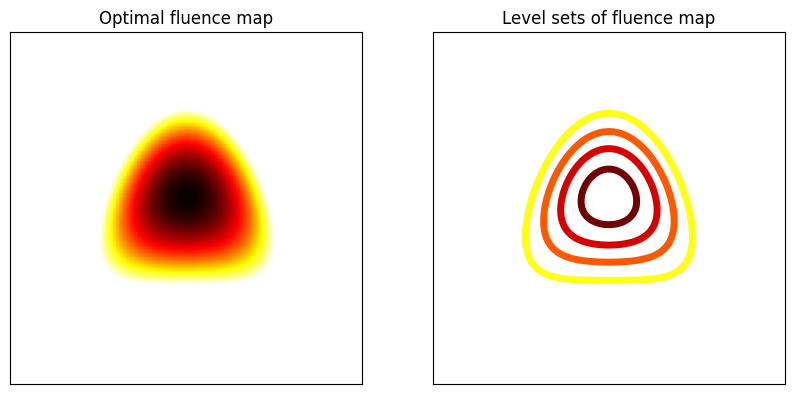

In [3]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Z[::-1], cmap='hot_r', interpolation='hermite', extent=(-2,2,-2,2))
plt.xticks([])
plt.yticks([])
plt.title('Optimal fluence map')

plt.subplot(1, 2, 2)
plt.contour(X, Y, Z, levels=LEVELS, cmap='hot_r', linewidths=5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.title('Level sets of fluence map')

# plt.savefig('_fluence_map_discretization.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [4]:
LEAF_WIDTH = 0.25
LEAF_LENGTH = 1.25

In [5]:
def get_leaf(direction, leaf_number, level, func, reverse=False):
    global LEAF_WIDTH, LEAF_LENGTH
    direction_length = np.sqrt(direction[0]**2 + direction[1]**2)
    direction = (direction[0]/direction_length, direction[1]/direction_length)
    x = direction[1] * LEAF_WIDTH * leaf_number
    x0 = x
    y = -direction[0] * LEAF_WIDTH * leaf_number
    y0 = y
    while x*x + y*y < 10:
        x -= direction[0]*0.01
        y -= direction[1]*0.01
    dx, dy = direction
    dx *= 0.01
    dy *= 0.01
    while func(x,y) < level and x*x + y*y < 100:
        x += dx
        y += dy
    x -= dx
    y -= dy
    if x*x + y*y >= 90:
        x = x0
        y = y0
    rx = x
    ry = y
    y = y - LEAF_WIDTH/2
    if not reverse:
        sx = -LEAF_LENGTH
    else:
        sx = LEAF_LENGTH
    sy = LEAF_WIDTH
    a = np.arctan2(direction[1], direction[0]) * (180/np.pi)
    a %= 180
    return plt.Rectangle((x, y), sx, sy, \
                         edgecolor='black', facecolor='grey', linewidth=2, \
                         rotation_point=(rx,ry), angle=a)


In [6]:
def get_leaf_pair(direction, leaf_number, level, func):
    leaf1 = get_leaf(direction, leaf_number, level, func)
    reverse_direction = (-direction[0], -direction[1])
    leaf2 = get_leaf(reverse_direction, leaf_number, level, func, reverse=True)
    return leaf1, leaf2

In [7]:
def plot_leaves_level(fluence_function, level, levels=None, direction=(1,0), number_leaves=5):
    Z = fluence_function(X, Y)
    plt.contour(X, Y, Z, levels, cmap='hot_r', linewidths=3, alpha=0.8)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    for leaf_number in range(-number_leaves, number_leaves+1):
        r1, r2 = get_leaf_pair(direction, leaf_number, level, fluence_function)
        plt.gca().add_patch(r1)
        plt.gca().add_patch(r2)

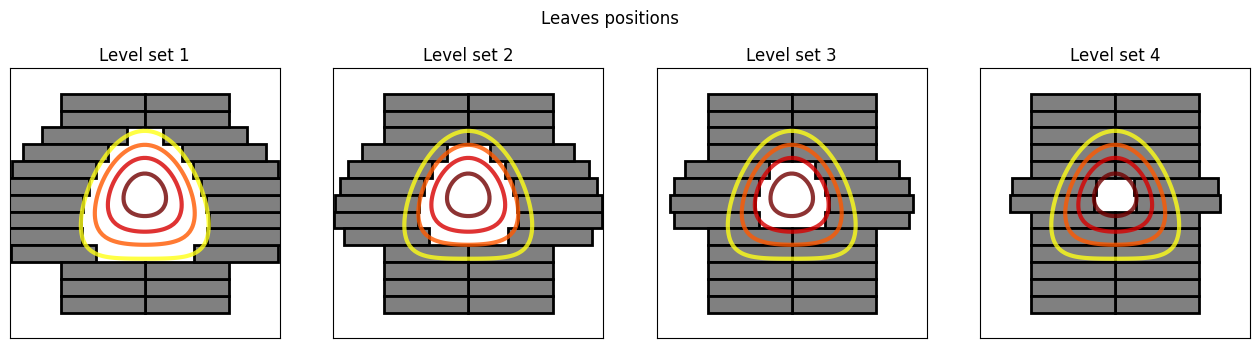

In [8]:
def plot_leaves_levels(fluence_function, direction=(1,0), number_leaves=5, levels=None, filename=None):
    global LEVELS
    if levels is None:
        levels = LEVELS
    N = len(levels)-2
    plt.figure(figsize=(4*N, 4))
    for i,level in enumerate(levels[1:-1]):
        plt.subplot(1, N, i+1)
        plot_leaves_level(fluence_function, level, levels, direction, number_leaves)
        plt.title(f'Level set {i+1}')
    plt.suptitle('Leaves positions')
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_leaves_levels(flu, number_leaves=6)
# plot_leaves_levels(flu, number_leaves=6, filename='_level_set_matching_with_leaves.pdf')

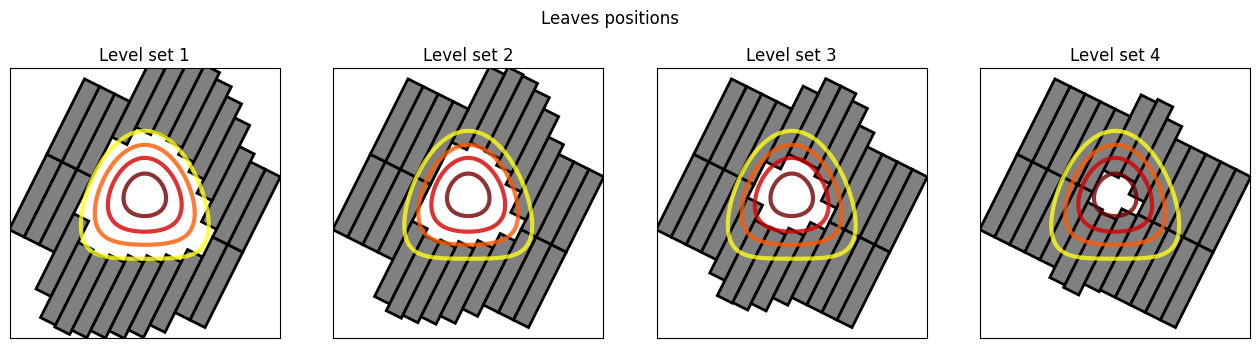

In [9]:
# just to show off
plot_leaves_levels(flu, (1,2), number_leaves=6)

In [10]:
# slightly non-convex fluence map
def flu0(x, y):
    return FLU(x, y, c=1.6)


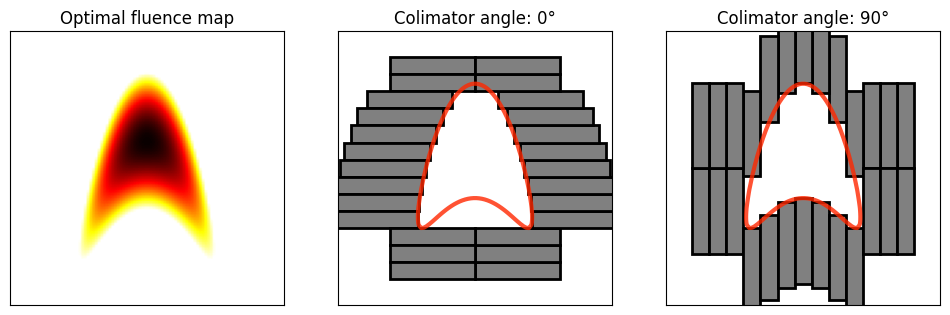

In [11]:
def plot_leaves_directions(fluence_function, directions=[(1,0), (0,1)], number_leaves=5, levels=[-2, 0.3, 2], filename=None):
    N = len(directions)
    plt.figure(figsize=(4*(N+1), 4))
    plt.subplot(1, N+1, 1)
    Z = fluence_function(X, Y)
    plt.imshow(Z[::-1], cmap='hot_r', interpolation='hermite', extent=(-2,2,-2,2))
    plt.xticks([])
    plt.yticks([])
    plt.title('Optimal fluence map')
    level = levels[1]
    for i,direction in enumerate(directions):
        plt.subplot(1, N+1, i+2)
        plot_leaves_level(fluence_function, level, levels, direction, number_leaves)
        angle = round(np.arctan2(direction[1], direction[0]) * (180/np.pi))
        plt.title(f'Colimator angle: {angle}°')
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()

plot_leaves_directions(flu0, number_leaves=6)
# plot_leaves_directions(flu0, number_leaves=6, filename='_leaves_angle.pdf')

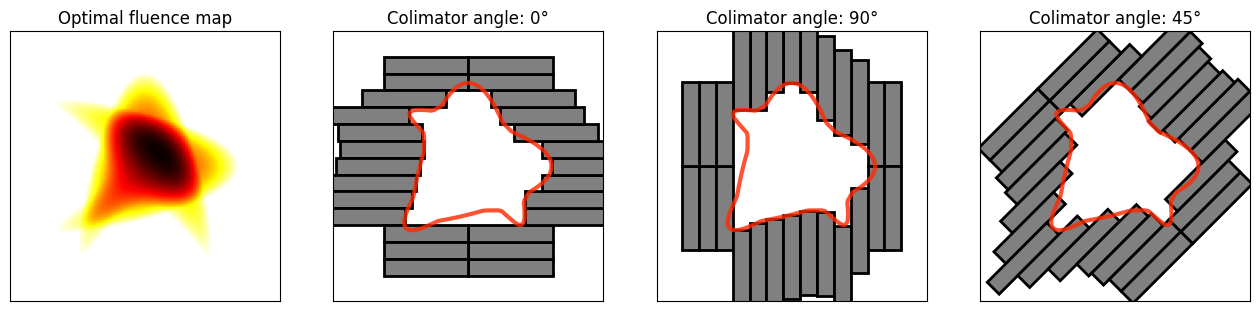

In [12]:
# slightly non-convex fluence map
def flu1(x, y):
    return flu0(x, y) + flu0(y, x)

plot_leaves_directions(flu1, directions=[(1,0), (0,1), (1,1)], number_leaves=6)


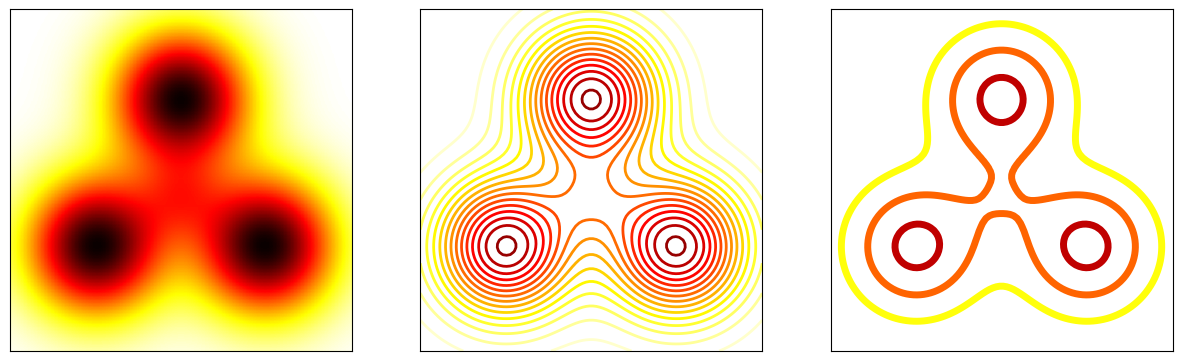

In [13]:
def flu2(x, y):
    def dist(x1, y1, x2, y2):
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)
    def bump(x):
        return np.exp(-x**2)
    c = 1.25
    d1 = dist(x, y, -1, -np.sqrt(3)/3 -0.2)
    d2 = dist(x, y, 1, -np.sqrt(3)/3 -0.2)
    d3 = dist(x, y, 0, np.sqrt(3)*2/3 -0.2)
    d4 = dist(x, y, 0, -0.2)
    z = bump(c*d1) + bump(c*d2) + bump(c*d3) + 0.25 * bump(2*d4)
    return z

plt.figure(figsize=(15, 5) )
Z = flu2(X, Y)

plt.subplot(1, 3, 1)
plt.imshow(Z[::-1], cmap='hot_r', interpolation='hermite', extent=(-2,2,-2,2))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
lvl = flu2(0,0)-0.01
plt.contour(X, Y, Z, levels=[0, 0.5*lvl, lvl, 1.5*lvl, 1.25], cmap='hot_r', linewidths=5)
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal')

plt.subplot(1, 3, 2)
plt.contour(X, Y, Z, levels=np.linspace(0, 1.25, 20), cmap='hot_r', linewidths=2)
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect('equal')

plt.show()


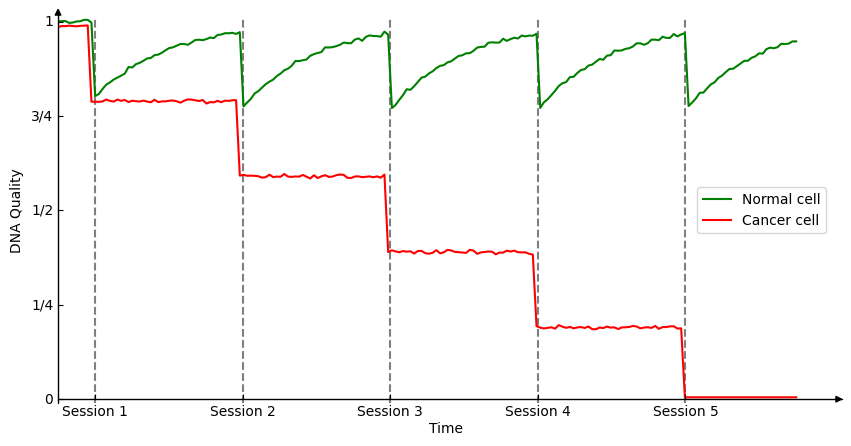

In [14]:
N = 200
RAND = 0.003
NB = 5
TMAX = 2 * NB
time = np.linspace(0, TMAX, N)
def irradiation_normal(x, t, factor=0.4):
    return -factor*(np.exp(-x+t).clip(0,1) + np.sign(x-t)*0.5 - 0.5)

def irradiation_cancer(x, t, factor=0.4):
    return -factor*(np.sign(x-t)*0.5 - 0.5)

irradiation_factors = [0.4, 0.3, 0.2, 0.1]
irradiation_factors = [0.2] * NB
irradiation_times = [0.5 + 2*i for i in range(NB)]
normal_cell = 1 + RAND*np.random.randn(N)
cancer_cell = -0.01 + RAND*np.random.randn(N)
for t, factor in zip(irradiation_times, irradiation_factors):
    normal_cell += irradiation_normal(time, t, factor)
    cancer_cell += irradiation_cancer(time, t-0.05, factor)
normal_cell = normal_cell.clip(0.005, 1.005)
cancer_cell = cancer_cell.clip(0.005, 1.005)

# plot configuration
plt.figure(figsize=(10,5)).add_subplot(axes_class=AxesZero)
# render axis lines
plt.gca().axis["xzero"].set_visible(True)
plt.gca().axis["yzero"].set_visible(True)
# arrow style
plt.gca().axis["xzero"].set_axisline_style("-|>")
plt.gca().axis["yzero"].set_axisline_style("-|>")
# do not draw frame
plt.gca().axis["top"].set_visible(False)
plt.gca().axis["bottom"].set_visible(False)
plt.gca().axis["right"].set_visible(False)
plt.gca().axis["left"].set_visible(False)

# plot irradiation times as vertical lines
for t in irradiation_times:
    plt.gca().axvline(t, color='k', linestyle='--', alpha=0.5)
# plot DNA quality
plt.plot(time, normal_cell, color='green', label='Normal cell')
plt.plot(time, cancer_cell, color='red', label='Cancer cell')
plt.legend(loc='center right')
plt.xlim(0, None)
plt.xlabel('Time')
plt.xticks(irradiation_times, [f'Session {i+1}' for i in range(len(irradiation_times))])
plt.ylim(-0.01, 1.01)
plt.ylabel('DNA Quality')
plt.yticks([0, 0.25, 0.5, 0.75, 1], ['0', '1/4', '1/2', '3/4', '1'])
# plt.title('DNA Quality over Time')

# plt.savefig('_dna_quality.pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()